## Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, log_loss, f1_score
import os
import h5py
import nltk
nltk.download('punkt')
from torchsummary import summary
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch.optim as optim
from torch._C import NoneType
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn.functional as F

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df=pd.read_csv("dataset.csv")
display(df.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
print(df.dtypes)

print("\n")
print("Number of entries: ", len(df) )
print("Number of features:", df.shape[1])

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


Number of entries:  14640
Number of features: 15


In [ ]:
int_col = df.select_dtypes(include=['int64']).columns.tolist()
float_col = df.select_dtypes(include=['float64']).columns.tolist()
object_col = df.select_dtypes(include=['object']).columns.tolist()

print(int_col)
print(float_col)
print(object_col)

['tweet_id', 'retweet_count']
['airline_sentiment_confidence', 'negativereason_confidence']
['airline_sentiment', 'negativereason', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


In [ ]:
#Handle Null Values
null_val = df.isnull().sum(axis=0)

print("Number of null values per column:")
print(null_val)

# if a column has many Null values drop the column

cols= ['tweet_id','airline_sentiment_gold', 'negativereason_gold', 'tweet_coord']
df_new= df.drop(columns=cols,axis=1)

print(df_new.columns)
print("\n")
replace_null_cols = ['tweet_location', 'user_timezone']

for i in replace_null_cols:
    mode_val = df_new[i].mode().iloc[0]
    df_new[i] = df[i].fillna(mode_val)


Number of null values per column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
Index(['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')




In [ ]:
null_val = df_new.isnull().sum(axis=0)

print("Number of null values per column:")
print(null_val)

Number of null values per column:
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                     0
user_timezone                      0
dtype: int64


In [ ]:
median_val = df['negativereason_confidence'].median()
df_new['negativereason_confidence'] = df_new['negativereason_confidence'].fillna(median_val)

df_new.fillna("Not Available",inplace=True)


for col in df_new.columns:
    print(f"Unique values in column '{col}':")
    # Print unique values of the column
    print(df_new[col].unique())
    print()


Unique values in column 'airline_sentiment':
['neutral' 'positive' 'negative']

Unique values in column 'airline_sentiment_confidence':
[1.     0.3486 0.6837 ... 0.6384 0.7094 0.3487]

Unique values in column 'negativereason':
['Not Available' 'Bad Flight' "Can't Tell" 'Late Flight'
 'Customer Service Issue' 'Flight Booking Problems' 'Lost Luggage'
 'Flight Attendant Complaints' 'Cancelled Flight' 'Damaged Luggage'
 'longlines']

Unique values in column 'negativereason_confidence':
[0.6706 0.     0.7033 ... 0.6234 0.644  0.7255]

Unique values in column 'airline':
['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']

Unique values in column 'name':
['cairdin' 'jnardino' 'yvonnalynn' ... 'KristenReenders' 'itsropes'
 'sanyabun']

Unique values in column 'retweet_count':
[ 0  1  2  3  4  5  7 22  6 18 15 31 11  8  9 28 32 44]

Unique values in column 'text':
['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky

In [ ]:
display(df_new.head())

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,Not Available,0.6706,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,"Boston, MA",Eastern Time (US & Canada)
1,positive,0.3486,Not Available,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,"Boston, MA",Pacific Time (US & Canada)
2,neutral,0.6837,Not Available,0.6706,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,"Boston, MA",Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,"Boston, MA",Pacific Time (US & Canada)


In [ ]:
#Main Statistics
df_numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

display(df_new.describe())
#Mean
mean=df[df_numerical].mean()
display(mean)

#Median
median=df[df_numerical].median()
display(median)

#Mode
mode=df[cat_cols].mode()
display(mode)

#min and max
min_values=df[df_numerical].min()
max_values=df[df_numerical].max()
display(min_values)
display(max_values)

#quartiles

display(df[df_numerical].quantile(0.25))
display(df[df_numerical].quantile(0.50))
display(df[df_numerical].quantile(0.75))

#counts
print(df.nunique())

#standard deviation
deviation=df[df_numerical].std()
display(deviation)

,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,14640.000000,14640.000000,14640.000000
mean,0.900169,0.647384,0.082650
std,0.162830,0.280510,0.745778
min,0.335000,0.000000,0.000000
25%,0.692300,0.645800,0.000000
50%,1.000000,0.670600,0.000000
75%,1.000000,0.703300,0.000000
max,1.000000,1.000000,44.000000


tweet_id                        5.692184e+17
airline_sentiment_confidence    9.001689e-01
negativereason_confidence       6.382983e-01
retweet_count                   8.265027e-02
dtype: float64

tweet_id                        5.694779e+17
airline_sentiment_confidence    1.000000e+00
negativereason_confidence       6.706000e-01
retweet_count                   0.000000e+00
dtype: float64

,airline_sentiment,negativereason,airline,airline_sentiment_gold,name,negativereason_gold,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,negative,Customer Service Issue,United,negative,JetBlueNews,Customer Service Issue,@united thanks,"[0.0, 0.0]",2015-02-24 09:54:34 -0800,"Boston, MA",Eastern Time (US & Canada)


tweet_id                        5.675883e+17
airline_sentiment_confidence    3.350000e-01
negativereason_confidence       0.000000e+00
retweet_count                   0.000000e+00
dtype: float64

tweet_id                        5.703106e+17
airline_sentiment_confidence    1.000000e+00
negativereason_confidence       1.000000e+00
retweet_count                   4.400000e+01
dtype: float64

tweet_id                        5.685592e+17
airline_sentiment_confidence    6.923000e-01
negativereason_confidence       3.606000e-01
retweet_count                   0.000000e+00
Name: 0.25, dtype: float64

tweet_id                        5.694779e+17
airline_sentiment_confidence    1.000000e+00
negativereason_confidence       6.706000e-01
retweet_count                   0.000000e+00
Name: 0.5, dtype: float64

tweet_id                        5.698905e+17
airline_sentiment_confidence    1.000000e+00
negativereason_confidence       1.000000e+00
retweet_count                   0.000000e+00
Name: 0.75, dtype: float64

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64


tweet_id                        7.791112e+14
airline_sentiment_confidence    1.628300e-01
negativereason_confidence       3.304398e-01
retweet_count                   7.457782e-01
dtype: float64

## Visualizations

<ipython-input-56-b2ad8f9ee0bf>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette=colors)


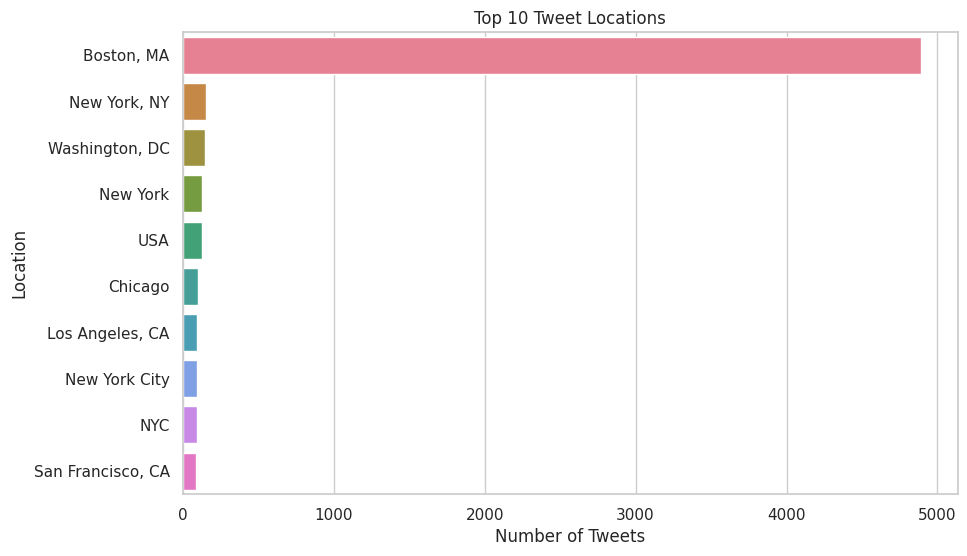

In [ ]:
#Visualizations
top_locations = df_new['tweet_location'].value_counts().nlargest(10)

colors = sns.color_palette("husl", len(top_locations))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, palette=colors)
plt.title('Top 10 Tweet Locations')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()


<ipython-input-57-053762ea8191>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence', data=df_new, estimator='mean', ci=None, color='skyblue')


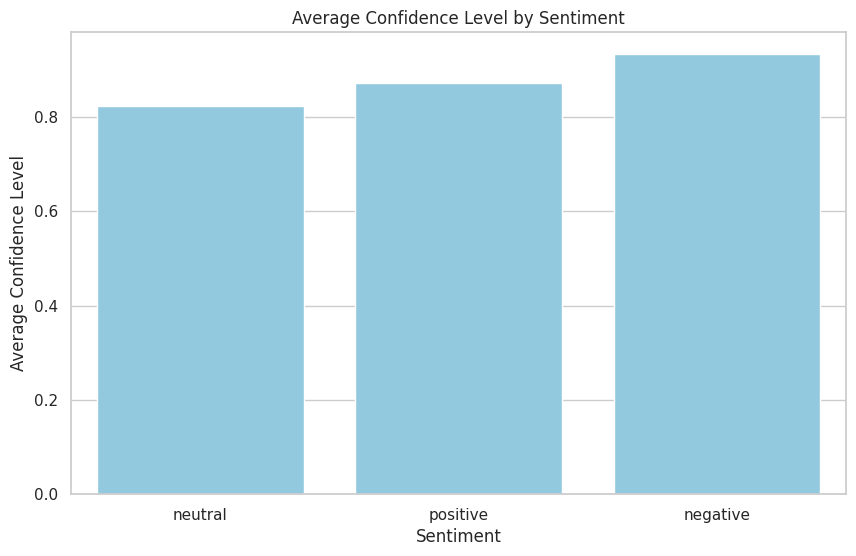

In [ ]:
df_new['tweet_length'] = df_new['text'].apply(len)


df_new['tweet_created_date'] = pd.to_datetime(df_new['tweet_created']).dt.date

plt.figure(figsize=(10, 6))
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence', data=df_new, estimator='mean', ci=None, color='skyblue')
plt.title('Average Confidence Level by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Confidence Level')
plt.show()


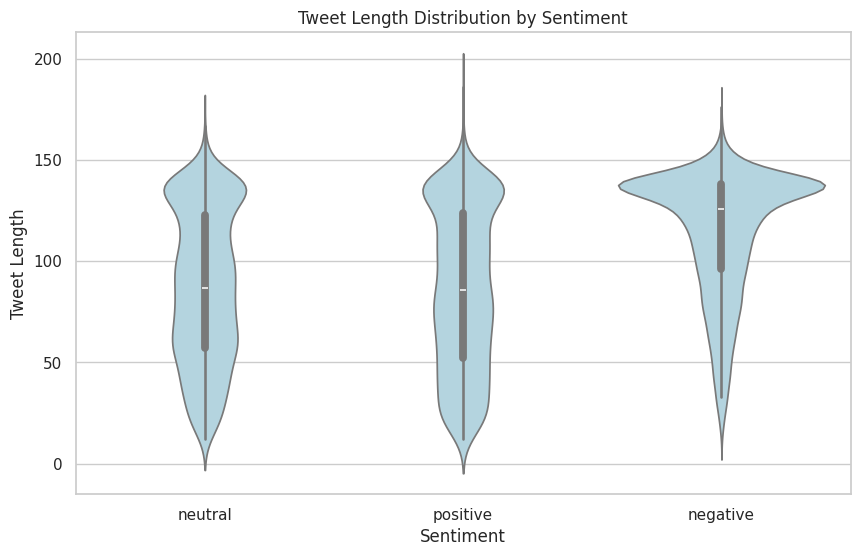

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='airline_sentiment', y='tweet_length', data=df_new,color="lightblue")
plt.title('Tweet Length Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length')
plt.show()

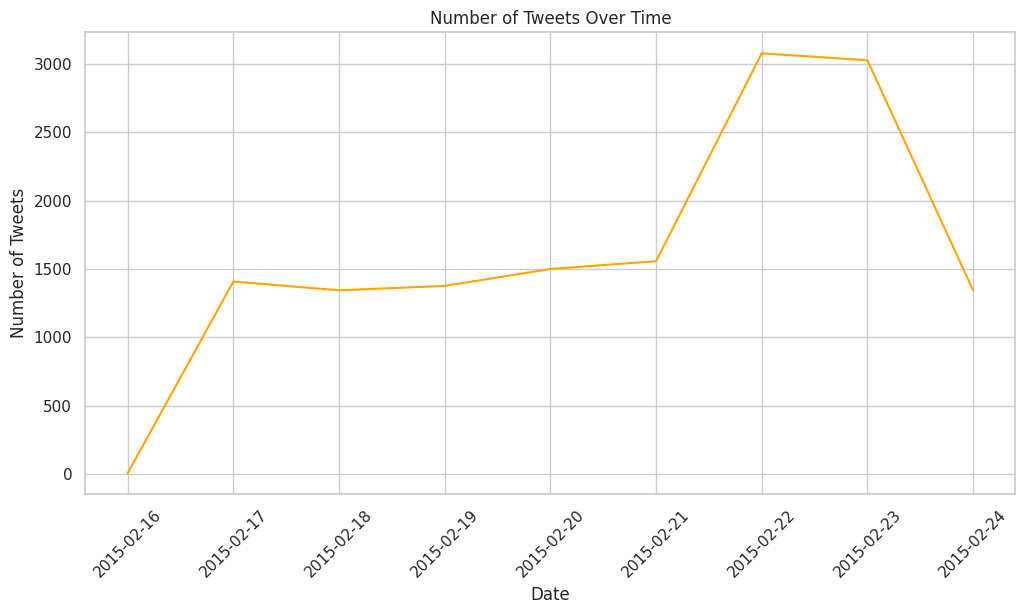

In [ ]:
tweets_over_time = df_new.groupby('tweet_created_date').size()

plt.figure(figsize=(12, 6))
sns.lineplot(data=tweets_over_time, color='orange')  # Change color here
plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Building a Vocabulary
texts=df_new["text"]
word_counts = Counter(word for text in texts for word in word_tokenize(text.lower()))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<OOV>"] = 1

vocab_size = len(vocab)

max_len = 200
encoded_sequences = []
for text in texts:
    encoded = [vocab.get(word, vocab["<OOV>"]) for word in word_tokenize(text.lower())]
    padded = np.zeros(max_len, dtype=int)
    padded[:len(encoded)] = encoded[:max_len]
    encoded_sequences.append(padded)

encoded_sequences = np.array(encoded_sequences)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['airline_sentiment'])
labels = np.array(labels)

In [ ]:
#Splitting
X_train, X_temp, y_train, y_temp = train_test_split(encoded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


((10248, 200), (10248,), (2196, 200), (2196,), (2196, 200), (2196,))

In [ ]:
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long)), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long)), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)), shuffle=False, batch_size=64)

## Defining LSTM Model

In [ ]:
class base_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, output_dim=3, num_layers=3, dropout=0.1):
        super(base_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=dropout, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        lstm_out1, _ = self.lstm1(embedded)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out3, _ = self.lstm3(lstm_out2)
        # Taking the final hidden state from the last layer
        hidden = self.dropout(lstm_out3[:, -1, :])
        output = self.fc(hidden.squeeze(0))
        return output

size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = base_LSTM(size).to(device)
print(model)
# summary(model,input_size=(64,))

cuda
base_LSTM(
  (embedding): Embedding(17065, 128)
  (lstm1): LSTM(128, 256, batch_first=True, dropout=0.1)
  (lstm2): LSTM(256, 256, batch_first=True, dropout=0.1)
  (lstm3): LSTM(256, 256, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=8):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 61.57%  Train Loss: 0.9350479293313826  Validation Accuracy: 62.61%  Validation Loss: 0.9244401948792594
Epoch: 2  Train Accuracy: 62.35%  Train Loss: 0.921590266760832  Validation Accuracy: 62.61%  Validation Loss: 0.9211107560566494
Epoch: 3  Train Accuracy: 62.57%  Train Loss: 0.9181087472424003  Validation Accuracy: 62.61%  Validation Loss: 0.9182810119220188
Epoch: 4  Train Accuracy: 61.80%  Train Loss: 0.9281969237031403  Validation Accuracy: 62.61%  Validation Loss: 0.9213066492761884
Epoch: 5  Train Accuracy: 61.99%  Train Loss: 0.9250156479592649  Validation Accuracy: 62.61%  Validation Loss: 0.92309695822852
Epoch: 6  Train Accuracy: 61.79%  Train Loss: 0.9277785053904752  Validation Accuracy: 62.61%  Validation Loss: 0.9198871765817914
Epoch: 7  Train Accuracy: 61.89%  Train Loss: 0.9261640136286339  Validation Accuracy: 62.61%  Validation Loss: 0.9183477980749948
Epoch: 8  Train Accuracy: 62.34%  Train Loss: 0.9214034324847393  Validation Accuracy:

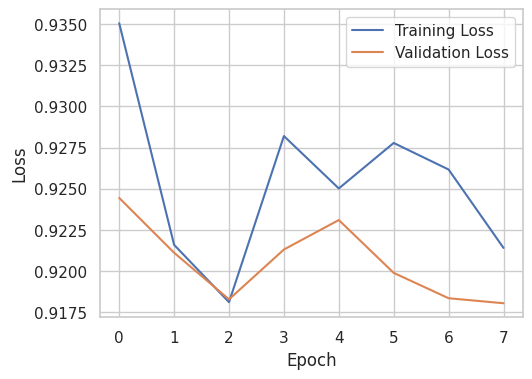

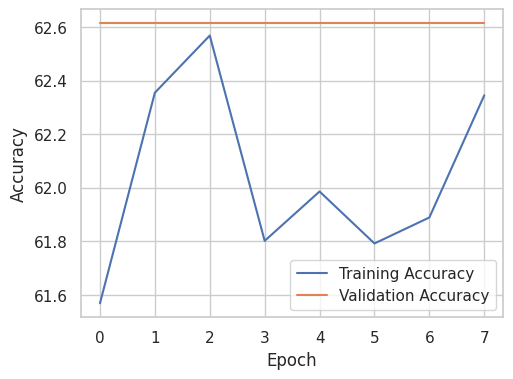

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=8)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 65 %
Test Loss: 0.8797277535711016


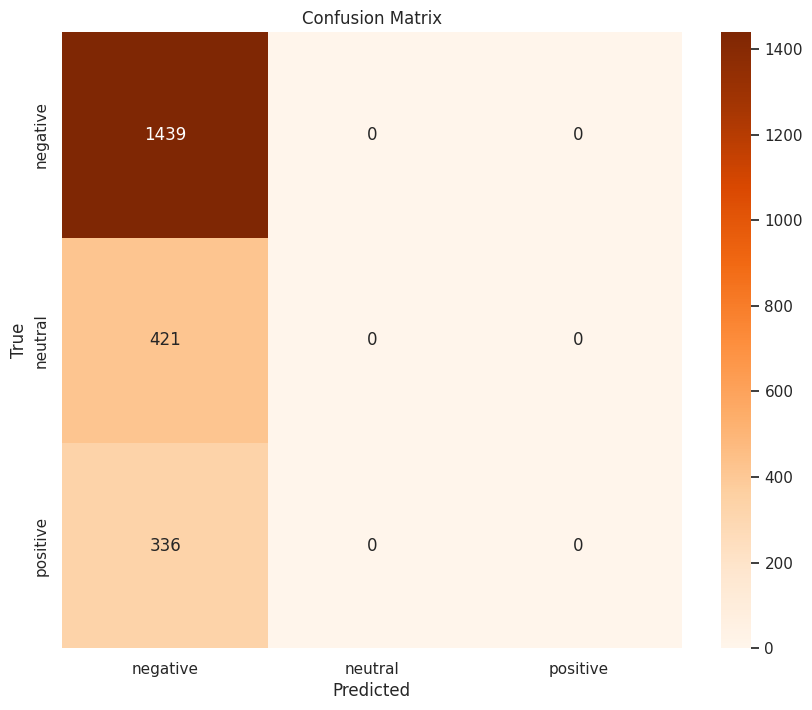

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.43
Recall: 0.66
F1 Score: 0.52


In [ ]:
torch.save(model.state_dict(), 'part4_LSTM.h5')

In [ ]:
class base_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, output_dim=3, num_layers=3, dropout=0.1):
        super(base_BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.bilstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=dropout, batch_first=True, bidirectional=True)
        self.bilstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, dropout=dropout, batch_first=True, bidirectional=True)
        self.bilstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        bilstm_out1, _ = self.bilstm1(embedded)
        bilstm_out2, _ = self.bilstm2(bilstm_out1)
        bilstm_out3, _ = self.bilstm3(bilstm_out2)
        hidden = self.dropout(torch.cat((bilstm_out3[:, -1, :self.hidden_dim], bilstm_out3[:, 0, self.hidden_dim:]), dim=1))
        output = self.fc(hidden.squeeze(0))
        return output

size = len(vocab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = base_BiLSTM(size).to(device)
print(model)


cuda
base_BiLSTM(
  (embedding): Embedding(17065, 128)
  (bilstm1): LSTM(128, 256, batch_first=True, dropout=0.1, bidirectional=True)
  (bilstm2): LSTM(512, 256, batch_first=True, dropout=0.1, bidirectional=True)
  (bilstm3): LSTM(512, 256, batch_first=True, dropout=0.1, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=8):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 64.64%  Train Loss: 0.8390029468891783  Validation Accuracy: 68.26%  Validation Loss: 0.7707662037440709
Epoch: 2  Train Accuracy: 69.79%  Train Loss: 0.7170042841701034  Validation Accuracy: 72.54%  Validation Loss: 0.6863693961075374
Epoch: 3  Train Accuracy: 74.14%  Train Loss: 0.6241866503813251  Validation Accuracy: 74.00%  Validation Loss: 0.6309297059263502
Epoch: 4  Train Accuracy: 77.21%  Train Loss: 0.5659569146470254  Validation Accuracy: 74.82%  Validation Loss: 0.6243951320648193
Epoch: 5  Train Accuracy: 79.74%  Train Loss: 0.5092566029995865  Validation Accuracy: 76.41%  Validation Loss: 0.6125994443893432
Epoch: 6  Train Accuracy: 80.66%  Train Loss: 0.4920282284295337  Validation Accuracy: 77.69%  Validation Loss: 0.5683397242001125
Epoch: 7  Train Accuracy: 82.24%  Train Loss: 0.45967308852983557  Validation Accuracy: 77.87%  Validation Loss: 0.5699965562139239
Epoch: 8  Train Accuracy: 83.02%  Train Loss: 0.430996304713421  Validation Accura

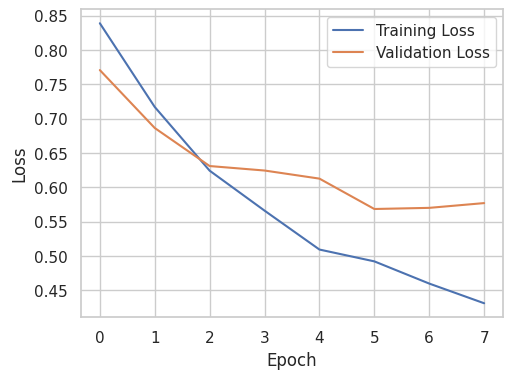

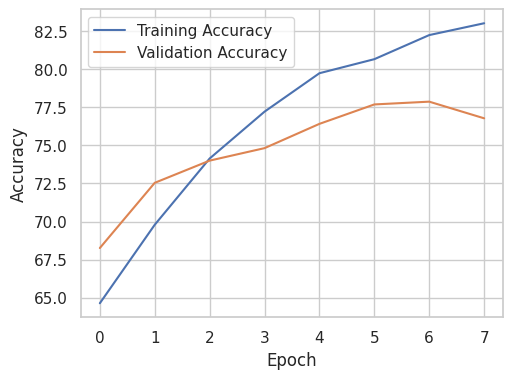

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=8)

In [ ]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 79 %
Test Loss: 0.5354373267718724


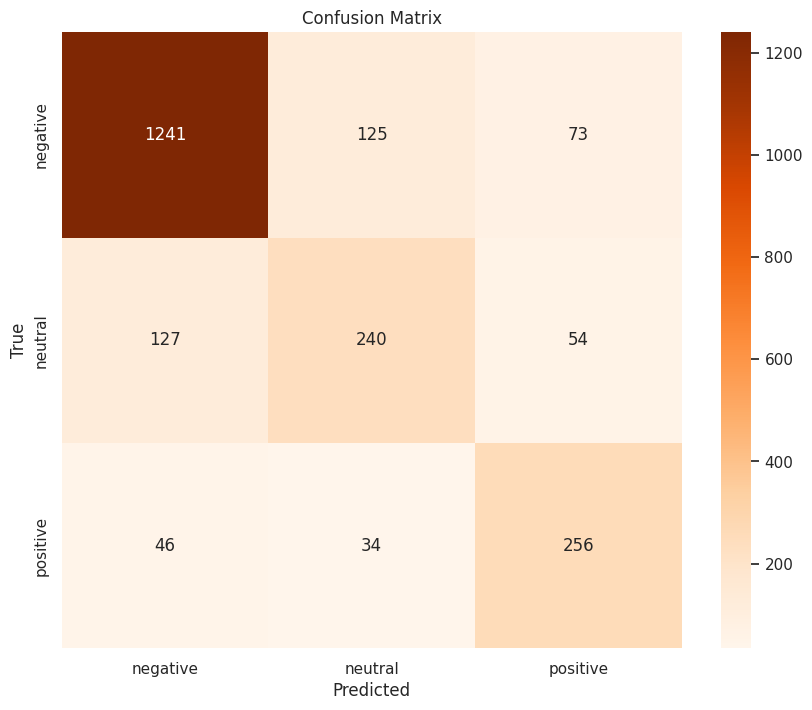

In [ ]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted',zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.79
Recall: 0.79
F1 Score: 0.79


In [ ]:
torch.save(model.state_dict(), 'part4_BiLSTM.h5')

## References

1. https://arxiv.org/abs/1409.1556
2. https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
3. https://en.wikipedia.org/wiki/Early_stopping
4. https://pytorch.org/vision/stable/transforms.html
5. CSE 574 Machine Learning Assignment 2 submission by Dharma. Acha
6. https://pandas.pydata.org/
7. https://pytorch.org/vision/stable/models.html